In [3]:
import os

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [4]:
from pathlib import Path
import hydra_zen
from omegaconf import OmegaConf
import torch
import xarray as xr
import lightning as L
import numpy as np
import importlib
import matplotlib.pyplot as plt
import glob
from data_module import WindDirectionDataModule
import simple_conv

importlib.reload(simple_conv)
from simple_conv import MyModel
import math
from scipy import stats
import pandas as pd
import hydra

# Use function

In [5]:
def load_from_cfg(
    cfg_path,
    key,
    overrides=None,
    overrides_targets=None,
    cfg_hydra_path=None,
    call=True,
):
    src_cfg = OmegaConf.load(Path(cfg_path))
    overrides = overrides or dict()
    OmegaConf.set_struct(src_cfg, True)
    if cfg_hydra_path is not None:
        hydra_cfg = OmegaConf.load(Path(cfg_hydra_path))
        OmegaConf.register_new_resolver(
            "hydra", lambda k: OmegaConf.select(hydra_cfg, k), replace=True
        )
    # with OmegaConf.open_dict(src_cfg):
    cfg = OmegaConf.merge(src_cfg, overrides)
    if overrides_targets is not None:
        for path, target in overrides_targets.items():
            node = OmegaConf.select(cfg, path)
            node._target_ = target
    if key is not None:
        cfg = OmegaConf.select(cfg, key)
    return hydra.utils.call(cfg) if call else cfg

In [6]:
from omegaconf import OmegaConf
from pathlib import Path
import torch


# Paths
xp_dir = Path(
    "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/best_model/simple_conv_mdn_2_4_128_7_True_0.0001_ren_ds"
)
cfg_path = xp_dir / ".hydra/config.yaml"
hydra_cfg_path = xp_dir / ".hydra/hydra.yaml"

model = load_from_cfg(
    cfg_path=str(cfg_path),
    key="model",
    cfg_hydra_path=str(hydra_cfg_path),
)
ckpt_xp_dir = xp_dir / "wind_direction_model/2_4_128_7_True_0.0001_ren_ds"
ckpt_path = next(ckpt_xp_dir.glob("checkpoints/*.ckpt"), None)

if ckpt_path is None:
    raise FileNotFoundError(f"No checkpoint found in {xp_dir / 'checkpoints/'}")

ckpt = torch.load(ckpt_path)
if "state_dict" not in ckpt:
    raise KeyError("Checkpoint does not contain 'state_dict'")

model.load_state_dict(ckpt["state_dict"])


/tmp/ipykernel_1839585/1245222490.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


<All keys matched successfully>

In [7]:
ckpt

{'state_dict': OrderedDict([('mod.1.weight',
               tensor([[[[-0.4572, -0.3858, -0.2489],
                         [-0.2418, -0.2206,  0.1621],
                         [-0.0431,  0.4523,  0.6688]],
               
                        [[-0.0762, -0.1084,  0.0387],
                         [-0.1729, -0.1351, -0.0012],
                         [-0.1319,  0.0792, -0.0660]]],
               
               
                       [[[ 0.3848, -0.2740,  0.3306],
                         [ 0.3194, -0.5973,  0.0783],
                         [ 0.1298, -0.4039,  0.2975]],
               
                        [[-0.0560, -0.0247,  0.0361],
                         [-0.1326, -0.0190,  0.1065],
                         [-0.0180,  0.0765, -0.1129]]],
               
               
                       [[[ 0.2890,  0.4335,  0.2570],
                         [-0.4872, -0.5131, -0.3755],
                         [ 0.3676,  0.4470,  0.4893]],
               
                        [[

In [6]:
trainer = load_from_cfg(
    cfg_path=cfg_path,
    key="trainer",
    cfg_hydra_path=hydra_cfg_path,
    overrides=dict(trainer=dict(logger=dict(save_dir="tmp"))),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
# model = load_from_cfg(
#     cfg_path=cfg_path,
#     key="model",
#     cfg_hydra_path=hydra_cfg_path,
#     overrides=dict(model=dict(checkpoint_path=ckpt_path)),
#     overrides_targets=dict(model="simple_conv.MyModel.load_from_checkpoint"),
# )

In [14]:
model.eval()

MyModel(
  (criterion): CustomLoss()
  (mod): Sequential(
    (0): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (1): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Reduce('batch channel (h h2) (w w2) -> batch channel h w', 'max', w2=4, h2=4)
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Identity()
      (3): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Identity()
      (3): ReLU()
    )
    (5): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Identity

In [9]:
def load_data(path, checkpoint, inc=2, pol="VV"):
    data_module = WindDirectionDataModule(test_data_paths=path, inc=inc, pol=pol)
    data_module.train_mean = checkpoint["train_mean"]
    data_module.train_std = checkpoint["train_std"]
    data_module.setup(stage="predict")
    dataloader = data_module.test_dataloader()
    return dataloader, data_module

In [1]:
path = "/raid/localscratch/jrmiadan/coloc/exec_dir/ascat_s1/metop_a_s1/arctic_ocean/wind_dir_0_45/hh_hv/arctic_ocean_0_45_angle_6_10_speed_hh_hv.nc"

In [10]:
dataloader, data_module = load_data(path=path, checkpoint=ckpt, inc=2, pol="VV")

In [28]:
y_pred = []
for batch in dataloader:
    X, _ = batch
    preds, uncer = model(X)
    y_pred.append(preds)
    break

In [32]:
y_pred, uncertainty = predict(model, dataloader, model_mdn=True)

In [35]:
xr.open_dataset(path)

<xarray.Dataset> Size: 21MB
Dimensions:              (tile: 133, tile_line: 44, tile_sample: 44, pol: 2)
Coordinates:
    line                 (tile, tile_line) float64 47kB ...
    sample               (tile, tile_sample) float64 47kB ...
  * pol                  (pol) <U2 16B 'HH' 'HV'
Dimensions without coordinates: tile, tile_line, tile_sample
Data variables: (12/18)
    ground_heading       (tile, tile_line, tile_sample) float32 1MB ...
    land_mask            (tile, tile_line, tile_sample) float32 1MB ...
    incidence            (tile, tile_line, tile_sample) float64 2MB ...
    longitude            (tile, tile_line, tile_sample) float64 2MB ...
    latitude             (tile, tile_line, tile_sample) float64 2MB ...
    nesz                 (tile, pol, tile_line, tile_sample) float64 4MB ...
    ...                   ...
    lon_centroid         (tile) float64 1kB ...
    lat_centroid         (tile) float64 1kB ...
    spatial_ref          (tile) float64 1kB ...
    origin_safe          (tile) <U72 38kB ...
    coloc_scat_path      (tile) <U151 80kB ...
    sar_ref_wind_dir     (tile) float64 1kB ...
Attributes: (12/15)
    short_name:                SENTINEL1_DS:S1A_IW_GRDH_1SDH_20191126T042035_...
    safe:                      S1A_IW_GRDH_1SDH_20191126T042035_20191126T0420...
    swath:                     IW
    ipf:                       3.1
    platform:                  SENTINEL-1A
    start_date:                2019-11-26 04:20:35.181472
    ...                        ...
    tile_size:                 17600m*17600m (line * sample)
    resolution:                400m
    polarizations:             HH HV
    processing_level:          GRDH
    main_footprint:            POLYGON ((-168.1530978458791 70.44093031916799...
    platform_heading(degree):  -25.35620176875416

In [34]:
len(y_pred)

133

In [30]:
def load_model(
    model_path,
    inc,
    hid,
    depth,
    model_mdn=True,
    down=4,
    weight_decay=None,
    num_gaussians=2,
):
    checkpoint = torch.load(model_path)
    model = MyModel(
        inc=inc,
        hid=hid,
        depth=depth,
        model_mdn=model_mdn,
        down=down,
        weight_decay=weight_decay,
        num_gaussians=num_gaussians,
    )
    model.load_state_dict(checkpoint["state_dict"])
    return model, checkpoint


def load_data(path, checkpoint, inc=2, pol="VV"):
    data_module = WindDirectionDataModule(test_data_paths=path, inc=inc, pol=pol)
    data_module.train_mean = checkpoint["train_mean"]
    data_module.train_std = checkpoint["train_std"]
    data_module.setup(stage="predict")
    dataloader = data_module.test_dataloader()
    return dataloader, data_module


def predict(model, dataloader, model_mdn=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    y_pred = []
    uncertainty = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            X, _ = batch
            X = X.to(device)

            if model_mdn:
                preds, uncer = model(X)
                y_pred.append(preds)
                uncertainty.append(uncer)
            else:
                preds = model(X)
                y_pred.append(preds)
        y_pred = torch.concat(y_pred).cpu()

        if model_mdn:
            uncertainty = torch.cat(uncertainty, dim=0).cpu()
            return y_pred.squeeze(), uncertainty

        return y_pred.squeeze()


def loss_cos(y_true, y_pred, ambi=False):
    err = y_pred - y_true
    if not ambi:
        err = err / 2
    loss = 1 - torch.square(torch.cos(err))
    return torch.mean(loss)

In [3]:
def get_histogram_2d_variables(x_column, y_column, nbins=100):
    x_min, x_max = np.min(x_column), np.max(x_column)
    y_min, y_max = np.min(y_column), np.max(y_column)

    kernel = stats.gaussian_kde([x_column, y_column])
    xi, yi = np.mgrid[x_min : x_max : nbins * 1j, y_min : y_max : nbins * 1j]
    zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))

    return xi, yi, zi.reshape(xi.shape)


def hist2d_prediction_vs_reference(
    x, y, pred_std, pol, sat, title, mod=False, delta_time=30
):
    if pol == "VV" or pol == "VH" or pol == "VV-VH":
        color = "Greens"
        color_h = "green"
    elif pol == "HH" or pol == "HV" or pol == "HH-HV":
        color = "Blues"
        color_h = "#1f77b4"

    X, Y, Z = get_histogram_2d_variables(x, y)

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(6, 1),
        height_ratios=(1, 6),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.05,
    )

    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.pcolormesh(X, Y, Z, shading="auto", cmap=color)
    ax.set_xlabel("Reference angle (°)", fontsize=14)
    ax.set_ylabel("Predicted angle (°)", fontsize=14)
    ax.set_xlim(0, 180)
    ax.set_ylim(0, 180)

    nbins = 90
    binwidth = 180 / nbins

    bins = np.arange(0, 180 + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, alpha=0.75, color=color_h)
    ax_histx.grid(linestyle="--", color="gray", alpha=0.9)
    ax_histx.set_xlim(0, 180)
    ax_histy.hist(y, bins=bins, orientation="horizontal", alpha=0.75, color=color_h)
    ax_histy.grid(linestyle="--", color="gray", alpha=0.9)
    ax_histy.set_ylim(0, 180)

    ax.grid(linestyle="--", color="gray", alpha=0.9)

    x_series = pd.Series(x)
    y_series = pd.Series(y)

    diff_serie = (y_series - x_series % 180).apply(
        lambda v: -1 * np.sign(v) * 180 + v if np.abs(v) > 90 else v
    )
    bias = diff_serie.mean()
    std = diff_serie.std()
    nb_points = len(x)

    txt_str = "Number of points: %d \nBias: %.2f° | Std: %.2f°" % (nb_points, bias, std)

    if pred_std:
        title_str = f"{sat} ({pol}) predicted angle & HY2b angle\nDiff_time_max: {delta_time}min, STD predicted: [0 - {pred_std.values.max():.2f}]°"
    else:
        if mod:
            title_str = f"{sat} ({pol}) predicted angle & HY2b angle\nDiff_time_max: {delta_time}min {title} mod90"

        else:
            title_str = f"{sat} ({pol}) predicted angle & HY2b angle\nDiff_time_max: {delta_time}min {title}"
    props = dict(boxstyle="square", facecolor="white")

    ax.text(
        0.05,
        0.95,
        txt_str,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=props,
    )
    ax.plot([0, 180], [0, 180], color="k", linestyle="--")
    plt.suptitle(title_str, fontsize=20)

    plt.show()


In [5]:
# mod = "2024-08-29/15-47-01/0/wind_direction_model/1_4_128_5_False_None_ren_ds"
# model_old = f"/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/{mod}/checkpoints/best-checkpoint.ckpt"
model_old = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/best_model/simple_conv_mdn_2_4_128_7_True_0.0001_ren_ds/wind_direction_model/2_4_128_7_True_0.0001_ren_ds/checkpoints/best-checkpoint.ckpt"
inc = 2
model_mdn = True
weight_decay = 0.0001
model, checkpoint = load_model(
    model_path=model_old,
    inc=inc,
    hid=128,
    depth=7,
    model_mdn=model_mdn,
    down=4,
    weight_decay=weight_decay,
    num_gaussians=2,
)


/tmp/ipykernel_2356967/2229319834.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


# Renaud ds

## make tiles

In [ ]:
import sys

sys.path.append("/home1/datawork/jrmiadan/project/grdtiler/grdtiler")

In [7]:
import grdtiler
# import xsar

In [ ]:
import sys

sys.path.append("/raid/localscratch/jrmiadan/cds2/USE/")
from jr_use import get_s1_path

In [ ]:
safe = "S1B_IW_GRDH_1SDV_20210420T094117_20210420T094142_026549_032B99_0CD8.SAFE"
get_s1_path(safe)

'/home/datawork-cersat-public/project/mpc-sentinel1/data/esa/sentinel-1b/L1/IW/S1B_IW_GRDH_1S/2021/110/S1B_IW_GRDH_1SDV_20210420T094117_20210420T094142_026549_032B99_0CD8.SAFE'

In [ ]:
paths = [
    "/home/datawork-cersat-public/project/mpc-sentinel1/data/esa/sentinel-1b/L1/IW/S1B_IW_GRDH_1S/2021/110/S1B_IW_GRDH_1SDV_20210420T094232_20210420T094300_026549_032B99_34BE.SAFE",
    "/home/datawork-cersat-public/project/mpc-sentinel1/data/esa/sentinel-1b/L1/IW/S1B_IW_GRDH_1S/2021/110/S1B_IW_GRDH_1SDV_20210420T094207_20210420T094232_026549_032B99_993D.SAFE",
    "/home/datawork-cersat-public/project/mpc-sentinel1/data/esa/sentinel-1b/L1/IW/S1B_IW_GRDH_1S/2021/110/S1B_IW_GRDH_1SDV_20210420T094142_20210420T094207_026549_032B99_B760.SAFE",
    "/home/datawork-cersat-public/project/mpc-sentinel1/data/esa/sentinel-1b/L1/IW/S1B_IW_GRDH_1S/2021/110/S1B_IW_GRDH_1SDV_20210420T094117_20210420T094142_026549_032B99_0CD8.SAFE",
    "/home/datawork-cersat-public/project/mpc-sentinel1/data/esa/sentinel-1b/L1/IW/S1B_IW_GRDH_1S/2021/110/S1B_IW_GRDH_1SDV_20210420T094117_20210420T094142_026549_032B99_0CD8.SAFE",
]

In [11]:
ds_list = []
tiles_list = []

In [ ]:
for path in paths:
    ds, tiles = grdtiler.tiling_prod(path=path, tile_size=17600, resolution="400m")
    ds_list.append(ds)
    tiles_list.append(tiles)

/home1/datawork/jrmiadan/micromamba/envs/xsarml_env/lib/python3.11/site-packages/numpy/_core/numeric.py:452: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
DEBUG:xsarsea.windspeed:timing _gmf_function : 0.84s. mem: +39.7Mb
Adding footprints: 100%|██████████| 140/140 [00:06<00:00, 22.53it/s]
/home1/datawork/jrmiadan/micromamba/envs/xsarml_env/lib/python3.11/site-packages/numpy/_core/numeric.py:452: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
DEBUG:xsarsea.windspeed:timing _gmf_function : 0.00s. mem: +0.0Mb
Adding footprints: 100%|██████████| 126/126 [00:05<00:00, 24.18it/s]
/home1/datawork/jrmiadan/micromamba/envs/xsarml_env/lib/python3.11/site-packages/numpy/_core/numeric.py:452: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
DEBUG:xsarsea.windspeed:timing _gmf_function : 0.00s. mem: +0.0Mb
Adding footprints: 10

In [12]:
import matplotlib.pyplot as plt
from shapely import wkt

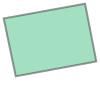

In [14]:
ds.main_footprint

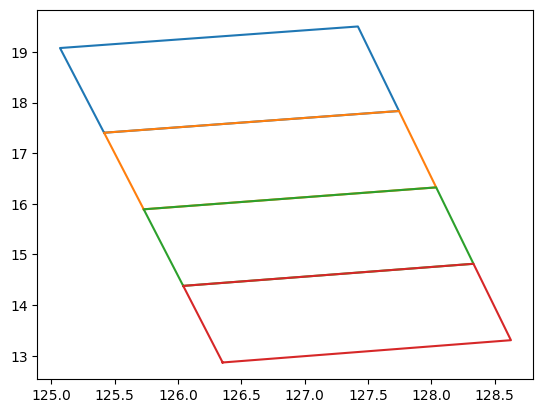

In [15]:
for ds in ds_list:
    poly = wkt.loads(str(ds.main_footprint))
    plt.plot(*poly.exterior.xy)

plt.show()

In [ ]:
ds_list[0].main_footprint.hvplot.polygons(geo=True)

<xarray.Dataset> Size: 22MB
Dimensions:         (line: 464, sample: 629, pol: 2)
Coordinates:
  * line            (line) float64 4kB 19.5 59.5 99.5 ... 1.85e+04 1.854e+04
  * sample          (sample) float64 5kB 19.5 59.5 99.5 ... 2.51e+04 2.514e+04
  * pol             (pol) object 16B 'VV' 'VH'
    spatial_ref     int64 8B 0
Data variables:
    ground_heading  (line, sample) float32 1MB dask.array<chunksize=(464, 629), meta=np.ndarray>
    land_mask       (line, sample) int8 292kB dask.array<chunksize=(464, 629), meta=np.ndarray>
    incidence       (line, sample) float64 2MB dask.array<chunksize=(464, 629), meta=np.ndarray>
    longitude       (line, sample) float64 2MB dask.array<chunksize=(464, 629), meta=np.ndarray>
    latitude        (line, sample) float64 2MB dask.array<chunksize=(464, 629), meta=np.ndarray>
    nesz            (pol, line, sample) float64 5MB dask.array<chunksize=(1, 464, 629), meta=np.ndarray>
    sigma0          (pol, line, sample) float64 5MB dask.array<chunksize=(1, 464, 629), meta=np.ndarray>
    sigma0_detrend  (pol, line, sample) float64 5MB dask.array<chunksize=(1, 464, 629), meta=np.ndarray>
Attributes: (12/15)
    short_name:                SENTINEL1_DS:S1B_IW_GRDH_1SDV_20210420T094232_...
    safe:                      S1B_IW_GRDH_1SDV_20210420T094232_20210420T0943...
    swath:                     IW
    ipf:                       3.31
    platform:                  SENTINEL-1B
    start_date:                2021-04-20 09:42:32.878864
    ...                        ...
    tile_size:                 17600m*17600m (line * sample)
    resolution:                400m
    polarizations:             VV VH
    processing_level:          GRDH
    main_footprint:            POLYGON ((125.4162170215354 17.40325869111265,...
    platform_heading(degree):  -12.18012906569359

In [24]:
pol = "VV"
sat = "S1"
if sat == "S1":
    theta_diff = 30
else:
    theta_diff = 60
if pol == "VV":
    path = f"/raid/localscratch/jrmiadan/analyse/analyse_ds/{sat.lower()}_ds_{pol.lower()}_vh.nc"
elif pol == "HH":
    path = f"/raid/localscratch/jrmiadan/analyse/analyse_ds/{sat.lower()}_ds_{pol.lower()}_hv.nc"

ds = xr.open_dataset(path)


In [ ]:
for i, tiles in enumerate(tiles_list):
    for attr in ["main_footprint", "specialHandlingRequired"]:
        if attr in tiles.attrs:
            tiles.attrs[attr] = str(tiles.attrs[attr])
    tiles.to_netcdf(f"tiles{i}.nc")

## prediction

In [ ]:
# Cyclone
sat = "S1"
pol = "VV"
if sat == "S1":
    theta_diff = 30
else:
    theta_diff = 60
path = "/raid/localscratch/jrmiadan/analyse/analyse_ds/s1_cyclone_ds_vv_vh.nc"
ds_0 = xr.open_dataset(path)


In [ ]:
import xarray as xr
import numpy as np

# Initialize data dictionary with required keys
data = {"tiles": {}, "y_pred_norm": {}}

for i in range(4):
    path = f"/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/tiles{i}.nc"

    # Open the dataset and assign to 'tiles'
    dataset = xr.open_dataset(path)
    data["tiles"][i] = dataset

    # Load data
    dataloader, data_module = load_data(
        path=path, checkpoint=checkpoint, inc=inc, pol="VV"
    )

    # Predict using the model
    if model_mdn:
        y_pred, uncertainty = predict(model, dataloader, model_mdn=model_mdn)
    else:
        y_pred = predict(model, dataloader, model_mdn=model_mdn)

    heading_angles = dataset.sel(pol="VV").ground_heading.values[0, 0, 0]

    # Normalize predictions
    y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles) % 180
    data["y_pred_norm"][i] = y_pred_norm


Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading i

In [ ]:
import cartopy

cartopy.config["pre_existing_data_dir"] = (
    "/home1/datawork/jrmdiana/conda/mybestenv/lib/python3.11/site-packages/cartopy"
)

In [ ]:
len(data["tiles"])

4

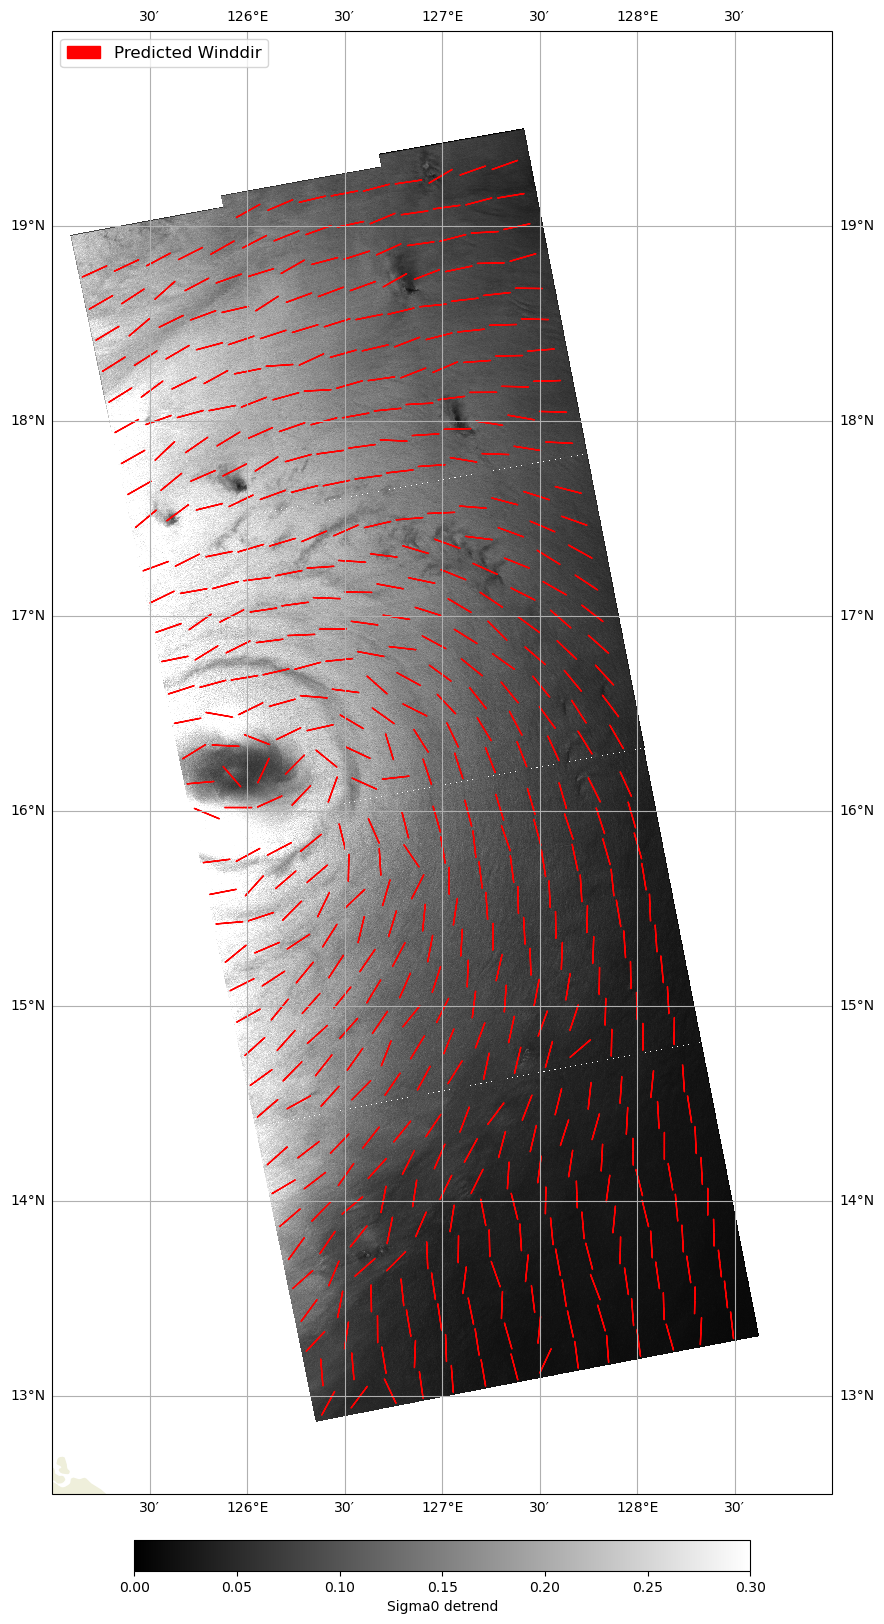

In [ ]:
fig, ax = plt.subplots(
    figsize=(18, 20), subplot_kw={"projection": cartopy.crs.PlateCarree()}
)
ax.set_aspect("equal")
land = cartopy.feature.NaturalEarthFeature(
    "physical",
    "land",
    "10m",
    edgecolor="face",
    facecolor=cartopy.feature.COLORS["land"],
)
ax.add_feature(land, zorder=0)
lg = False
for dt in range(len(data["tiles"])):
    tiles = data["tiles"][dt]
    y_pred_norm = data["y_pred_norm"][dt]
    for i in range(len(tiles.sel(pol="VV").tile)):
        arrow_scal = 0.07
        pred_y = y_pred_norm[i]
        angle_rad = np.deg2rad((90 - pred_y) % 180)
        dx = arrow_scal * np.cos(angle_rad)
        dy = arrow_scal * np.sin(angle_rad)
        tile = tiles.sel(pol="VV", tile=i)
        if not lg:
            ax.arrow(
                tile.lon_centroid,
                tile.lat_centroid,
                dx,
                dy,
                fc="red",
                ec="red",
                label="Predicted Winddir",
                zorder=2,
                head_width=0,
                width=0.000001,
            )
            ax.arrow(
                tile.lon_centroid,
                tile.lat_centroid,
                -dx,
                -dy,
                fc="red",
                ec="red",
                zorder=2,
                head_width=0,
                width=0.000001,
            )
            lg = True
        else:
            ax.arrow(
                tile.lon_centroid,
                tile.lat_centroid,
                dx,
                dy,
                fc="red",
                ec="red",
                zorder=2,
                head_width=0,
                width=0.000001,
            )
            ax.arrow(
                tile.lon_centroid,
                tile.lat_centroid,
                -dx,
                -dy,
                fc="red",
                ec="red",
                zorder=2,
                head_width=0,
                width=0.000001,
            )
    ds = ds_list[dt].sel(pol="VV")
    mesh = plt.pcolormesh(
        ds.longitude, ds.latitude, ds.sigma0, cmap="gray", vmin=0, vmax=0.3, zorder=1
    )
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=-1)
cbar = fig.colorbar(mesh, ax=ax, orientation="horizontal", fraction=0.02, pad=0.03)
cbar.set_label("Sigma0 detrend")
plt.legend(loc="upper left", fontsize=12)

plt.xlim([125, 129])
plt.ylim([12.5, 20])
plt.show()

In [ ]:
m

In [25]:
heading_angles = ds.sel(pol=pol).ground_heading.values[:, 0, 0]
y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles) % 180
y_hy2b = ds.sel(pol=pol).hy2b_wind_direction.values
# y_pred_rob = ds.sel(pol=pol).mean_wind_direction.values

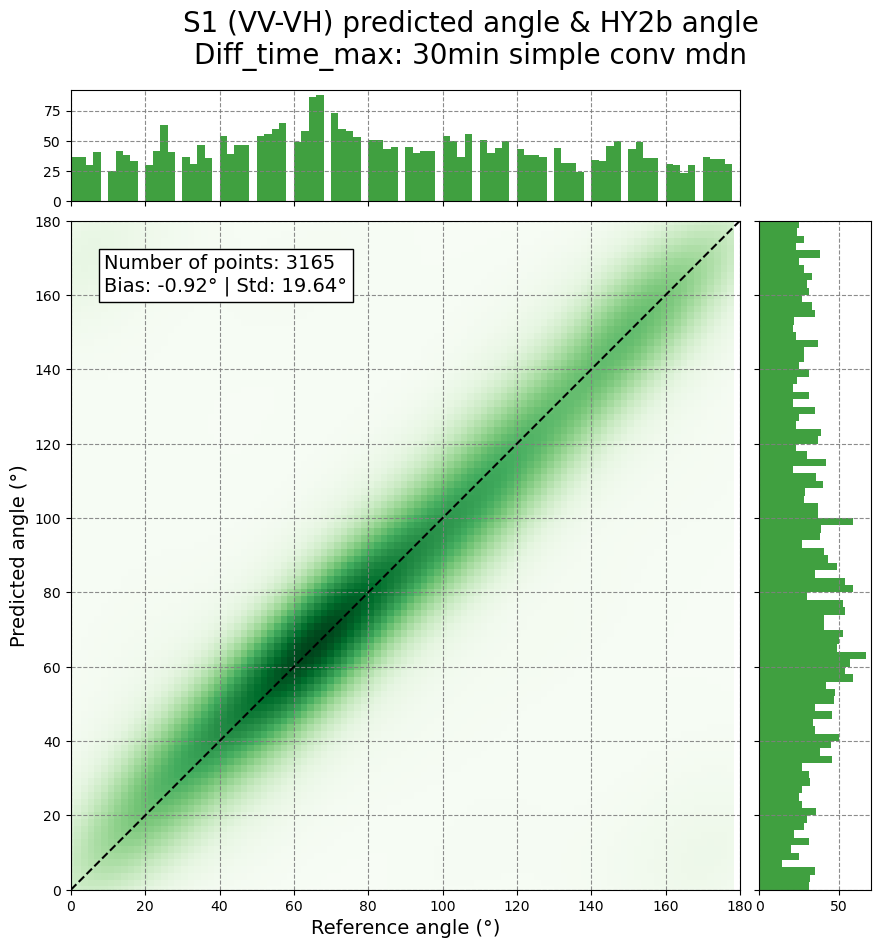

In [26]:
pol_plot = "VV-VH" if pol == "VV" else "HH-HV"
hist2d_prediction_vs_reference(
    x=np.array(y_hy2b) % 180,
    y=y_pred_norm,
    pred_std=None,
    title="simple conv mdn",
    pol=pol_plot,
    sat=sat,
    delta_time=theta_diff,
)

In [19]:
ds_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset/test_robin.nc"
xr.open_dataset(ds_path)

<xarray.Dataset> Size: 139MB
Dimensions:               (pol: 1, tile: 17733, tile_line: 44, tile_sample: 44)
Coordinates:
  * pol                   (pol) <U2 8B 'VV'
  * tile                  (tile) int64 142kB 0 1 2 3 ... 17729 17730 17731 17732
  * tile_line             (tile_line) int64 352B 0 1 2 3 4 5 ... 39 40 41 42 43
  * tile_sample           (tile_sample) int64 352B 0 1 2 3 4 ... 39 40 41 42 43
Data variables:
    sigma0_detrend        (pol, tile, tile_line, tile_sample) float32 137MB ...
    ref_angles            (pol, tile) float64 142kB ...
    ground_heading        (pol, tile) float64 142kB ...
    era5_angle            (pol, tile) float64 142kB ...
    era5_reference_angle  (pol, tile) float64 142kB ...
    mean_wind_direction   (pol, tile) float64 142kB ...
    wind_std              (pol, tile) float64 142kB ...
    pred_anlge            (tile) float64 142kB ...
    pred_angle            (tile) float64 142kB ...

In [12]:
ds_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset/test_robin.nc"
dataloader, data_module = load_data(path=ds_path, checkpoint=checkpoint, inc=inc)
y_pred = predict(model, dataloader, model_mdn=False)
# y_pred, uncertainty = predict(model, dataloader, model_mdn=True)


AssertionError: Size mismatch between tensors

In [ ]:
ds = xr.open_dataset(ds_path)

In [ ]:
y_era5 = (ds.sel(pol="VV").era5_angle.values) % 180
heading_angles = ds.sel(pol="VV").ground_heading.values
y_pred_norm = np.add(np.rad2deg(np.array(y_pred)), heading_angles) % 180

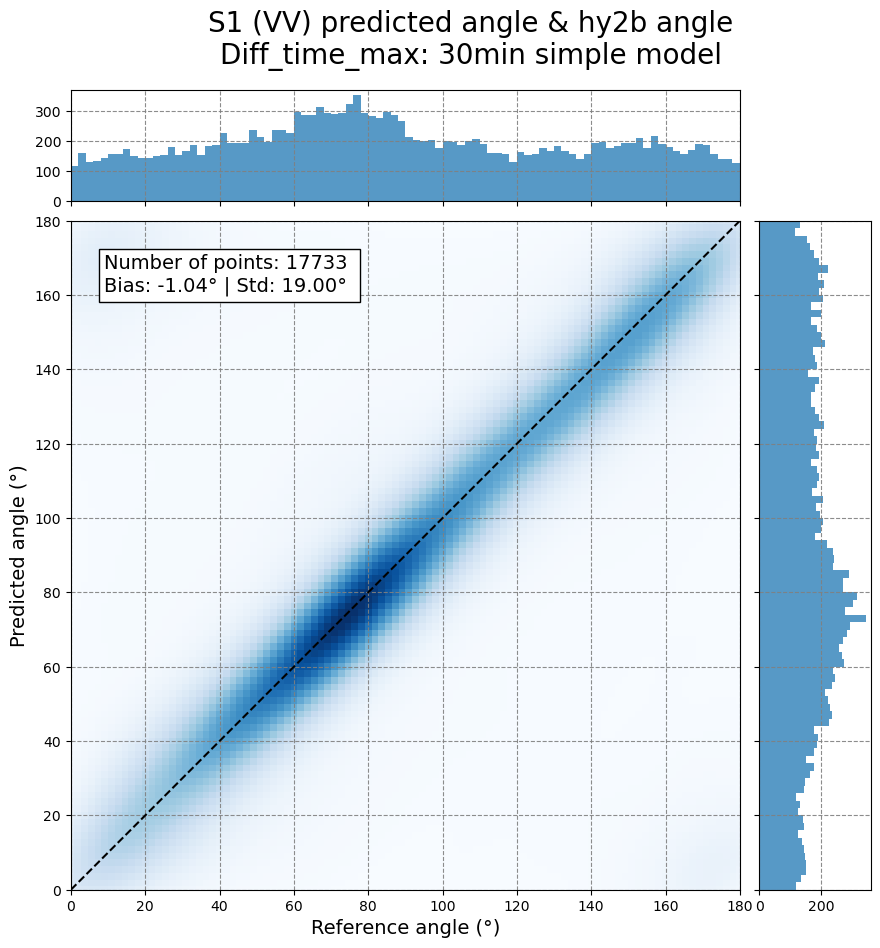

In [ ]:
hist2d_prediction_vs_reference(
    x=y_era5, y=y_pred_norm, pred_std=None, title="simple model", pol="VV"
)

In [ ]:
y_pred = ds.sel(pol="VV").pred_angle.values % 180
# hist2d_prediction_vs_reference(x=y_era5, y=y_pred, pred_std=None, title='Robin model', pol='VV')

In [ ]:
df_test = pd.DataFrame(
    {"reference_angle": y_era5, "Robin_pred": y_pred, "Simple_model": y_pred_norm}
)

y_true = torch.tensor(
    np.deg2rad(df_test["reference_angle"].values), dtype=torch.float32
)
y_pred_rob = torch.tensor(np.deg2rad(df_test["Robin_pred"].values), dtype=torch.float32)

rob_test_loss = loss_cos(y_true, y_pred_rob)

y_pred_ren = torch.tensor(
    np.deg2rad(df_test["Simple_model"].values), dtype=torch.float32
)

ren_test_loss = loss_cos(y_true, y_pred_ren)
print(f"Robin loss:{rob_test_loss}\nRenaud loss:{ren_test_loss}")

Robin loss:0.07488402724266052
Renaud loss:0.07365257292985916


# Analyse coloc

In [ ]:
df = pd.DataFrame(
    {
        "y_hy2b": y_hy2b,
        "y_pred_norm": y_pred_norm,
        "wind_speed": ds.hy2b_wind_speed.values,
    }
)

In [ ]:
df_filt = df[df["wind_speed"] > 15]

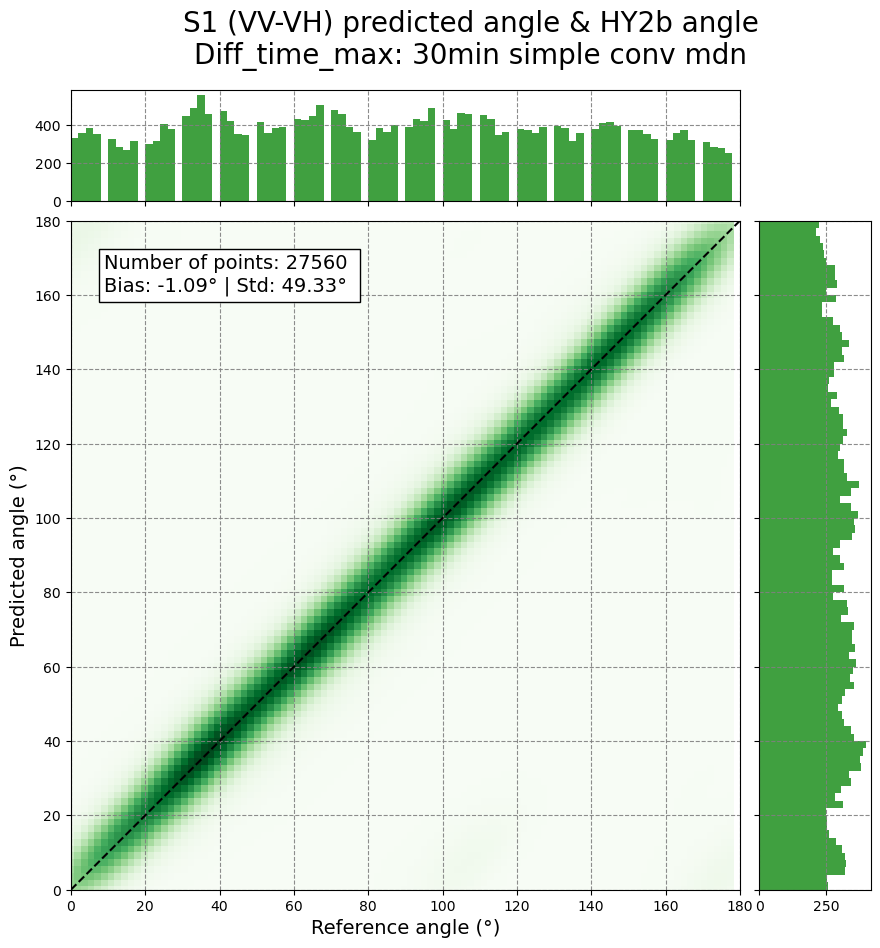

In [ ]:
pol_plot = "VV-VH" if pol == "VV" else "HH-HV"
hist2d_prediction_vs_reference(
    x=np.array(df_filt["y_hy2b"]) % 180,
    y=df_filt["y_pred_norm"],
    pred_std=None,
    title="simple conv mdn",
    pol=pol_plot,
    sat=sat,
    delta_time=theta_diff,
)